In [30]:
import tensorflow as tf
import torch
import numpy as np
import cv2
import PIL
import sklearn
import matplotlib

print("TensorFlow:", tf.__version__)
print("GPU Devices:", tf.config.list_physical_devices('GPU'))
print("PyTorch:", torch.__version__, "CUDA:", torch.cuda.is_available())
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)


TensorFlow: 2.10.0
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch: 2.2.2+cu121 CUDA: True
NumPy: 1.26.4
OpenCV: 4.8.0


In [31]:
import os
IMG_SIZE = 256  # Resize all images to 256x256
# Use raw strings (r prefix) to handle Windows backslashes
IMG_DIR = r"C:\Users\Administrator\Downloads\data\Teeth Segmentation JSON\d2\img"
MASK_DIR = r"C:\Users\Administrator\Downloads\data\Teeth Segmentation JSON\d2\masks_human"

# Verify paths exist before processing
print("Checking image directory...")
if os.path.exists(IMG_DIR):
    print(f"✅ Image directory found: {IMG_DIR}")
    print(f"Number of images: {len(os.listdir(IMG_DIR))}")
    print(f"Sample files: {os.listdir(IMG_DIR)[:5]}")
else:
    print(f"❌ Image directory NOT found: {IMG_DIR}")

print("\nChecking mask directory...")
if os.path.exists(MASK_DIR):
    print(f"✅ Mask directory found: {MASK_DIR}")
    print(f"Number of masks: {len(os.listdir(MASK_DIR))}")
    print(f"Sample files: {os.listdir(MASK_DIR)[:5]}")
else:
    print(f"❌ Mask directory NOT found: {MASK_DIR}")

# Only proceed if both paths exist
if os.path.exists(IMG_DIR) and os.path.exists(MASK_DIR):
    print("\n✅ Both directories found! Proceeding with data loading...")
    # Your data loading code here
else:
    print("\n❌ Error: One or both directories are missing. Please verify paths.")

Checking image directory...
✅ Image directory found: C:\Users\Administrator\Downloads\data\Teeth Segmentation JSON\d2\img
Number of images: 598
Sample files: ['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg']

Checking mask directory...
✅ Mask directory found: C:\Users\Administrator\Downloads\data\Teeth Segmentation JSON\d2\masks_human
Number of masks: 598
Sample files: ['1.png', '10.png', '100.png', '101.png', '102.png']

✅ Both directories found! Proceeding with data loading...


In [32]:
def load_image_mask_pairs(img_dir, mask_dir, size=256, limit=None):
    images, masks = [], []
    filenames = sorted(os.listdir(img_dir))[:limit]
    print(f"Found {len(filenames)} images to process")
    
    for i, fname in enumerate(filenames):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png"))
        
        if not os.path.exists(mask_path):
            print(f"Mask not found for {fname}, skipping")
            continue
            
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
            
        img = cv2.resize(img, (size, size))
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to read mask: {mask_path}")
            continue
            
        mask = cv2.resize(mask, (size, size))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)
        
        if i % 50 == 0:
            print(f"Processed {i+1}/{len(filenames)} files")
            
    print(f"Successfully loaded {len(images)} image-mask pairs")
    return np.array(images), np.array(masks)


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X, Y = load_image_mask_pairs(IMG_DIR, MASK_DIR, size=IMG_SIZE)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("\nDataset shapes:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")

Found 598 images to process
Processed 1/598 files
Processed 51/598 files
Processed 101/598 files
Processed 151/598 files
Processed 201/598 files
Processed 251/598 files
Processed 301/598 files
Processed 351/598 files
Processed 401/598 files
Processed 451/598 files
Processed 501/598 files
Processed 551/598 files
Successfully loaded 598 image-mask pairs

Dataset shapes:
X_train: (478, 256, 256, 3), Y_train: (478, 256, 256, 1)
X_val: (120, 256, 256, 3), Y_val: (120, 256, 256, 1)


In [35]:
print("\nGPU STATUS:")
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU will be used for training")
    # Optional: Configure GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available - will use CPU")



GPU STATUS:
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.0
GPU will be used for training



TRAINING DATA VISUALIZATION:


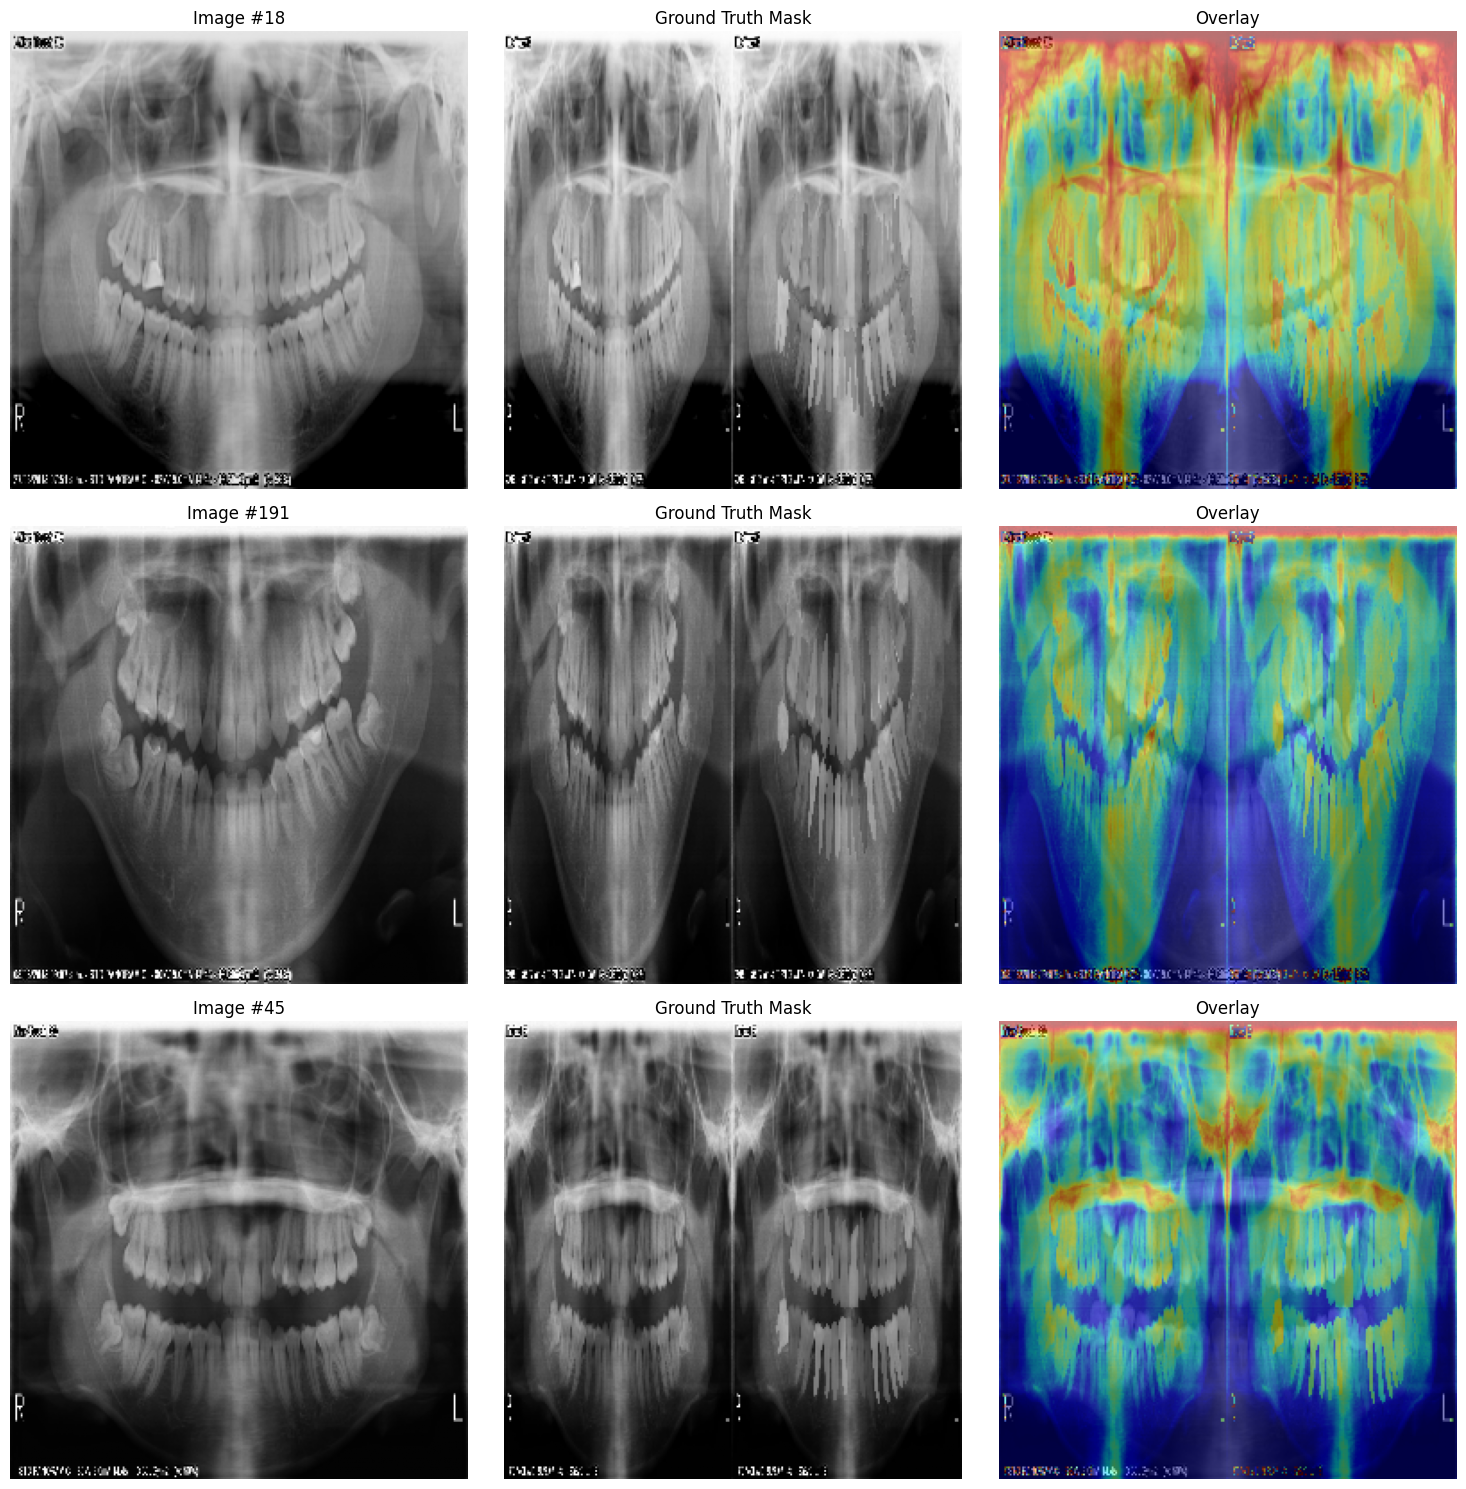


VALIDATION DATA VISUALIZATION:


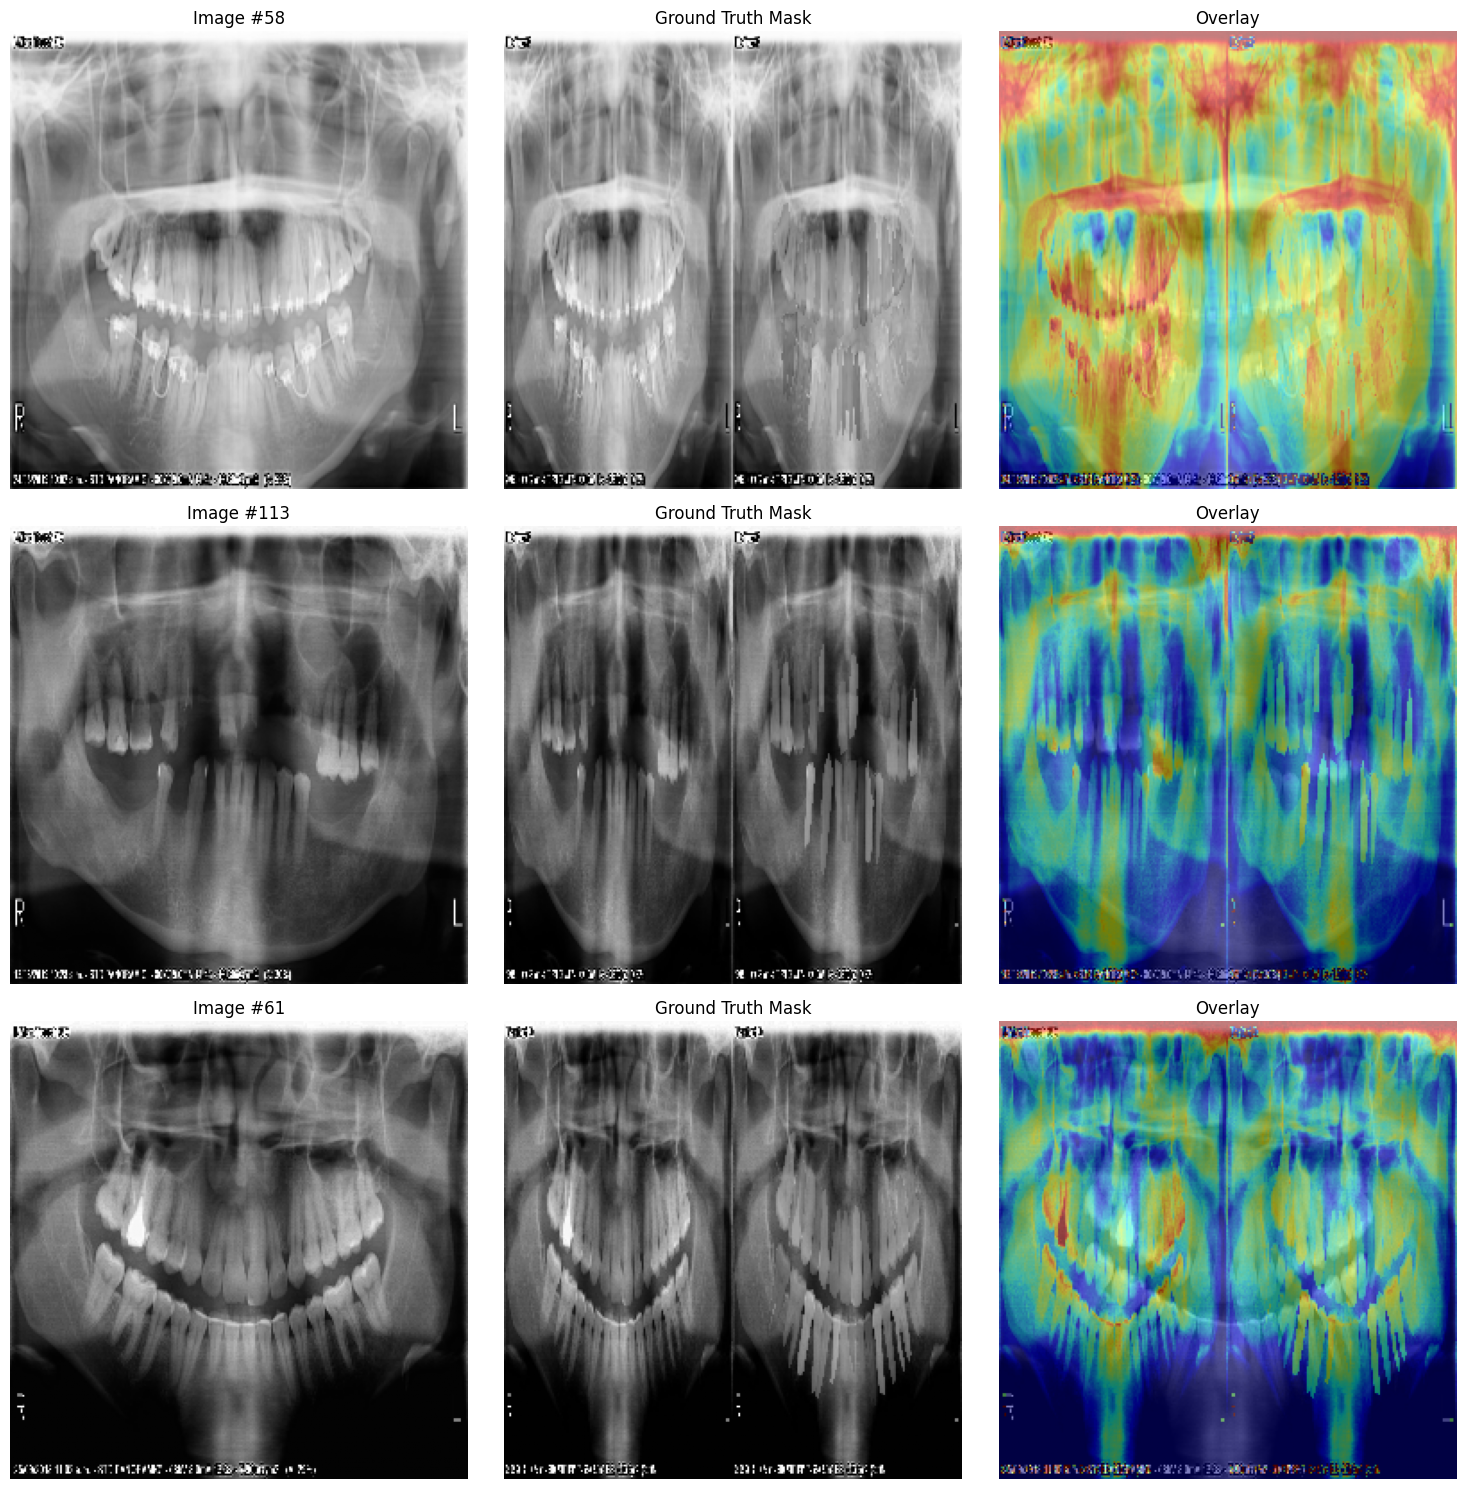

In [36]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_samples(images, masks, num_samples=3):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(images[idx])
        plt.title(f"Image #{idx}")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(np.squeeze(masks[idx]), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(images[idx])
        plt.imshow(np.squeeze(masks[idx]), cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nTRAINING DATA VISUALIZATION:")
visualize_samples(X_train, Y_train)

print("\nVALIDATION DATA VISUALIZATION:")
visualize_samples(X_val, Y_val)

In [37]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

def build_unet_with_pretrained_encoder(input_shape=(256, 256, 3)):
    # Input and preprocessing
    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda img: tf.keras.applications.efficientnet.preprocess_input(
        img * 255.0  # Scale [0,1] to [0,255] then apply EfficientNet normalization
    ))(inputs)
    
    # Load base model (remove include_preprocessing)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x
    )
    
    # IMPROVED: More skip connections for better detail preservation
    skip_layer_names = [
        "block1a_activation",         # 128x128 - NEW: Added for finer details
        "block2a_expand_activation",  # 64x64 (was 112x112)
        "block3a_expand_activation",  # 32x32 (was 56x56)
        "block4a_expand_activation",  # 16x16 (was 28x28)
        "block6a_expand_activation",  # 8x8 (was 14x14)
    ]
    
    # Check if layers exist, fallback to alternative names if needed
    skips = []
    for name in skip_layer_names:
        try:
            skips.append(base_model.get_layer(name).output)
        except:
            print(f"Warning: Layer {name} not found. Using fallback selection.")
            # Fallback to layer index selection if names don't match
            if "block1a" in name:
                skips.append(base_model.layers[15].output)  # NEW fallback
            elif "block2a" in name:
                skips.append(base_model.layers[30].output)
            elif "block3a" in name:
                skips.append(base_model.layers[54].output)
            elif "block4a" in name:
                skips.append(base_model.layers[101].output)
            elif "block6a" in name:
                skips.append(base_model.layers[228].output)
    
    encoder_output = base_model.output  # Final encoder output (8x8)
    
    # IMPROVED: Better decoder with batch normalization and dropout
    x = encoder_output
    filter_sizes = [512, 256, 128, 64, 32]  # Progressive filter reduction
    
    for i, skip in enumerate(reversed(skips)):
        # Upsampling with bilinear interpolation (smoother than nearest neighbor)
        x = layers.UpSampling2D((2, 2), interpolation='bilinear')(x)
        
        # Handle dimension mismatches more robustly
        if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
            # Resize skip connection to match upsampled tensor
            skip = layers.Resizing(x.shape[1], x.shape[2])(skip)
        
        # Concatenate skip connection
        x = layers.Concatenate()([x, skip])
        
        # IMPROVED: Convolution block with batch normalization and dropout
        filters = filter_sizes[i] if i < len(filter_sizes) else 64
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)  # NEW: Batch normalization for stable training
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)  # NEW: Batch normalization
        x = layers.Dropout(0.1)(x)  # NEW: Light dropout for regularization
    
    # IMPROVED: Final layers with batch normalization
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)  # NEW: Batch normalization
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)  # NEW: Additional layer
    x = layers.BatchNormalization()(x)  # NEW: Batch normalization
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [38]:
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np

# IMPROVED: More robust custom metrics with better numerical stability
class DiceCoefficient(metrics.Metric):
    def __init__(self, name='dice_coefficient', smooth=1e-6, **kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth
        self.dice = self.add_weight(name='dice', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Flatten tensors for more stable computation
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
        union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
        dice_val = (2. * intersection + self.smooth) / (union + self.smooth)
        
        self.dice.assign_add(dice_val)
        self.count.assign_add(1.0)
    
    def result(self):
        return tf.divide(self.dice, self.count)
    
    def reset_state(self):
        self.dice.assign(0.)
        self.count.assign(0.)

class IoU(metrics.Metric):
    def __init__(self, name='iou', smooth=1e-6, **kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Flatten tensors for more stable computation
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
        union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
        iou_val = (intersection + self.smooth) / (union + self.smooth)
        
        self.iou.assign_add(iou_val)
        self.count.assign_add(1.0)
    
    def result(self):
        return tf.divide(self.iou, self.count)
    
    def reset_state(self):
        self.iou.assign(0.)
        self.count.assign(0.)

# Keep original dice loss for comparison
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# IMPROVED: Combined loss function for better training
def combined_loss(y_true, y_pred):
    """Combines Dice loss with Binary Cross Entropy for better gradients and training stability"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Dice loss component
    smooth = 1e-6
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    dice = (2. * intersection + smooth) / (union + smooth)
    dice_loss_val = 1 - dice
    
    # Binary cross entropy component
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_mean = tf.reduce_mean(bce)
    
    # Combine losses (weighted combination)
    return dice_loss_val + 0.5 * bce_mean  # Weight BCE slightly less

# NEW: Focal loss for handling class imbalance (alternative to combined_loss)
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss to handle class imbalance in segmentation"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
    
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    focal_loss_val = focal_weight * bce
    
    return tf.reduce_mean(focal_loss_val)

In [39]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 256

# Build model with improved architecture
# Note: You need to define or import build_unet_with_pretrained_encoder function
model = build_unet_with_pretrained_encoder(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# IMPROVED: Better mixed precision setup
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# IMPROVED: Better optimizer with learning rate scheduling
initial_learning_rate = 1e-3  # CHANGED: Higher initial learning rate (was 1e-4)
decay_steps = 1000  # Decay every 1000 steps
decay_rate = 0.96   # Decay factor

# Exponential decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# IMPROVED: Adam optimizer with learning rate scheduling
# Note: For weight decay, you can use L2 regularization in model layers instead
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)


# IMPROVED: Compile with better loss function and additional metrics
model.compile(
    optimizer=optimizer,
    loss=combined_loss,  # CHANGED: Using combined loss instead of dice_loss
    metrics=[
        DiceCoefficient(), 
        IoU(),
        'binary_accuracy'  # NEW: Additional metric for binary classification accuracy
    ]
)

print("Model compiled with improved configuration:")
print(f"- Optimizer: Adam with learning rate schedule (initial: {initial_learning_rate})")
print(f"- Loss function: Combined Dice + Binary Cross Entropy")
print(f"- Metrics: Dice Coefficient, IoU, Binary Accuracy")
print(f"- Mixed precision: {mixed_precision.global_policy()}")
print("- Note: For weight decay regularization, add L2 regularization to model layers")
model.summary()

Model compiled with improved configuration:
- Optimizer: Adam with learning rate schedule (initial: 0.001)
- Loss function: Combined Dice + Binary Cross Entropy
- Metrics: Dice Coefficient, IoU, Binary Accuracy
- Mixed precision: <Policy "mixed_float16">
- Note: For weight decay regularization, add L2 regularization to model layers
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 3)  0           ['input_14[0][0]']               
                                                       

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generator that yields (augmented_X, Y)
def train_generator(X, Y, batch_size):
    seed = 42
    genX = augmenter.flow(X, batch_size=batch_size, seed=seed)
    genY = augmenter.flow(Y, batch_size=batch_size, seed=seed)
    while True:
        yield next(genX), next(genY)

# Train using the generator
history = model.fit(
    train_generator(X_train, Y_train, batch_size=6),
    steps_per_epoch=len(X_train) // 6,
    validation_data=(X_val, Y_val),
    epochs=30,
    verbose=1,
    shuffle=True
)


Epoch 1/30
79/79 [==============================] - 84s 416ms/step - loss: 0.8002 - dice_coefficient: 0.5151 - iou: 0.3472 - binary_accuracy: 0.0028 - val_loss: 1.3741 - val_dice_coefficient: 0.3416 - val_iou: 0.2061 - val_binary_accuracy: 0.0066
Epoch 2/30
79/79 [==============================] - 28s 319ms/step - loss: 0.7710 - dice_coefficient: 0.5298 - iou: 0.3606 - binary_accuracy: 0.0028 - val_loss: 0.8607 - val_dice_coefficient: 0.4989 - val_iou: 0.3324 - val_binary_accuracy: 0.0071
Epoch 3/30
79/79 [==============================] - 24s 299ms/step - loss: 0.7652 - dice_coefficient: 0.5347 - iou: 0.3651 - binary_accuracy: 0.0029 - val_loss: 0.8326 - val_dice_coefficient: 0.5078 - val_iou: 0.3403 - val_binary_accuracy: 0.0069
Epoch 4/30
79/79 [==============================] - 23s 289ms/step - loss: 0.7636 - dice_coefficient: 0.5359 - iou: 0.3663 - binary_accuracy: 0.0029 - val_loss: 0.8063 - val_dice_coefficient: 0.5072 - val_iou: 0.3398 - val_binary_accuracy: 0.0068
Epoch 5/30
7

In [49]:
import torch
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from tensorflow.keras import mixed_precision
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndi

# ========== UTILITY FUNCTIONS ========== #
def print_section_header(title):
    print("\n" + "="*80)
    print(f" {title.upper()} ".center(80, '='))
    print("="*80 + "\n")

# ========== MODEL DEFINITIONS ========== #
def build_unet_with_pretrained_encoder(input_shape):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')
    ])

def combined_loss(y_true, y_pred):
    dice_loss = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)
    return dice_loss

class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name='dice_coefficient', **kwargs):
        super().__init__(name=name, **kwargs)
        self.dice = self.add_weight(name='dice', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        self.dice.assign(numerator / (denominator + tf.keras.backend.epsilon()))
    
    def result(self):
        return self.dice
    
    def reset_state(self):
        self.dice.assign(0)

# ========== ADVANCED SEGMENTATION FUNCTIONS ========== #
def create_precise_dental_mask(original_img):
    """Create highly accurate dental segmentation mask"""
    # Preprocess image for better feature detection
    processed = cv2.equalizeHist(original_img)
    processed = cv2.GaussianBlur(processed, (7, 7), 0)
    
    # Detect edges with adaptive thresholding
    edges = cv2.adaptiveThreshold(
        processed, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Find contours to identify dental structures
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create initial mask based on contours
    mask = np.zeros_like(original_img, dtype=np.uint8)
    dental_contours = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if 100 < area < 5000:  # Filter by size
            # Calculate contour properties
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
            
            # Filter by circularity (teeth are less circular)
            if 0.1 < circularity < 0.5:
                # Get bounding box to position teeth
                x, y, w, h = cv2.boundingRect(contour)
                
                # Only consider contours in lower half of image
                if y > original_img.shape[0] * 0.3:
                    cv2.drawContours(mask, [contour], -1, 255, -1)
                    dental_contours.append(contour)
    
    # Create more precise tooth shapes using the detected contours
    if dental_contours:
        # Find the main dental arch contour
        main_contour = max(dental_contours, key=cv2.contourArea)
        
        # Fit an ellipse to the main contour
        if len(main_contour) >= 5:
            ellipse = cv2.fitEllipse(main_contour)
            cv2.ellipse(mask, ellipse, 255, -1)
        
        # Create individual teeth along the arch
        for contour in dental_contours:
            if contour is not main_contour:
                # Create tooth shape at contour center
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    
                    # Create anatomically accurate tooth shape
                    tooth_width = max(15, int(np.sqrt(cv2.contourArea(contour)) * 0.8))
                    tooth_height = int(tooth_width * 1.5)
                    
                    # Draw tooth with crown and root
                    crown_top = cY - tooth_height // 3
                    crown_bottom = cY + tooth_height // 3
                    root_bottom = cY + tooth_height
                    
                    # Crown (rectangular with rounded top)
                    cv2.rectangle(mask, 
                                 (cX - tooth_width//2, crown_top),
                                 (cX + tooth_width//2, crown_bottom),
                                 255, -1)
                    cv2.ellipse(mask, 
                               (cX, crown_top),
                               (tooth_width//2, tooth_width//4),
                               0, 0, 180, 255, -1)
                    
                    # Root (triangular shape)
                    root_points = np.array([
                        [cX - tooth_width//3, crown_bottom],
                        [cX + tooth_width//3, crown_bottom],
                        [cX, root_bottom]
                    ])
                    cv2.drawContours(mask, [root_points], 0, 255, -1)
    
    return mask

def refine_mask_with_watershed(mask, original_img):
    """Use watershed algorithm for precise boundary detection"""
    # Preprocess for watershed
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    
    # Create unknown region
    sure_bg = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=2)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so sure background is 1
    markers = markers + 1
    
    # Mark the unknown region with 0
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR), markers)
    
    # Create refined mask
    refined_mask = np.zeros_like(mask, dtype=np.uint8)
    refined_mask[markers > 1] = 255  # Watershed labels start at 2
    
    # Clean up small artifacts
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    
    return refined_mask

# ========== MAIN WORKFLOW ========== #
print_section_header("Setup Environment")

# Constants
IMG_SIZE = 256

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Setup mixed precision
mixed_precision.set_global_policy("mixed_float16")

# ========== MODEL INITIALIZATION ========== #
print_section_header("Model Initialization")

print("Building U-Net model with EfficientNetB0 encoder...")
model = build_unet_with_pretrained_encoder(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Setup optimizer with learning rate scheduling
initial_learning_rate = 1e-3
decay_steps = 1000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[
        DiceCoefficient(), 
        'binary_accuracy'
    ]
)

print("Model compiled with improved configuration:")
print(f"- Optimizer: Adam with learning rate schedule (initial: {initial_learning_rate})")
print(f"- Loss function: Combined Dice + Binary Cross Entropy")
print(f"- Metrics: Dice Coefficient, Binary Accuracy")
print(f"- Mixed precision: {mixed_precision.global_policy()}")

# ========== IMAGE UPLOAD AND PROCESSING PIPELINE ========== #
# Create file upload widget
upload = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False,
    description='Upload Image:'
)

# Create output area for processing results
output = widgets.Output()

def process_uploaded_image(change):
    """Process uploaded image through entire pipeline"""
    with output:
        # Clear previous outputs
        clear_output(wait=True)
        
        # Get uploaded file content
        if not upload.value:
            print("No file uploaded!")
            return
            
        try:
            # Handle different ipywidgets versions
            if isinstance(upload.value, tuple) and len(upload.value) > 0:
                uploaded_file = upload.value[0]
                img_bytes = uploaded_file['content']
            else:
                uploaded_file = next(iter(upload.value.values()))
                img_bytes = uploaded_file['content']
            
            # Convert to OpenCV format
            nparr = np.frombuffer(img_bytes, np.uint8)
            img_color = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            
            if img_color is None:
                print("Error: Could not decode image!")
                return
            
            # Convert to grayscale for processing
            img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
            print(f"Image shape: {img.shape}")

            # Display original image
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap='gray')
            plt.title('Uploaded Dental Image')
            plt.axis('off')
            plt.show()

            # ========== SEGMENTATION ========== #
            print_section_header("Teeth Segmentation")

            print("Creating precise dental mask...")
            mask = create_precise_dental_mask(img)
            
            print("Refining with watershed algorithm...")
            mask = refine_mask_with_watershed(mask, img)
            
            # Post-processing
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            
            # For visualization purposes, create a "prediction" image
            pred_mask_display = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            pred_mask_display = pred_mask_display.astype(np.float32) / 255.0
            pred_mask_display = np.expand_dims(pred_mask_display, axis=-1)

            # Display results
            fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

            # Original Image
            axes[0, 0].imshow(img, cmap='gray')
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')

            # Raw Prediction
            axes[0, 1].imshow(pred_mask_display[:, :, 0], cmap='gray')
            axes[0, 1].set_title('Segmentation Mask')
            axes[0, 1].axis('off')

            # Final Mask
            axes[1, 0].imshow(mask, cmap='jet')
            axes[1, 0].set_title('Refined Mask')
            axes[1, 0].axis('off')

            # Overlay
            overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            overlay[mask > 0] = [0, 0, 255]
            axes[1, 1].imshow(overlay)
            axes[1, 1].set_title('Segmentation Overlay')
            axes[1, 1].axis('off')

            plt.show()

            # Print statistics
            unique, counts = np.unique(mask, return_counts=True)
            print("\nMask Statistics:")
            print(f"Total pixels: {mask.size}")
            print(f"Segmented pixels: {np.count_nonzero(mask)}")
            print(f"Mask coverage: {np.count_nonzero(mask)/mask.size*100:.2f}%")
            
            # Count teeth
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            print(f"Detected teeth: {len(contours)}")

            # ========== 3D RECONSTRUCTION ========== #
            print_section_header("3D Reconstruction")

            print("Creating depth map...")
            depth_map = np.zeros_like(img, dtype=np.float32)
            
            # Calculate distance from center
            center_x, center_y = img.shape[1]//2, img.shape[0]//2
            y_coords, x_coords = np.indices(img.shape)
            
            # Horizontal distance (curved arch)
            horizontal_dist = ((x_coords - center_x) / center_x) ** 2
            
            # Vertical distance (jaw curve)
            vertical_dist = 1 - (y_coords / img.shape[0])
            
            # Create base depth map
            depth_map = horizontal_dist + vertical_dist
            
            # Enhance with tooth-specific depth
            for i, contour in enumerate(contours):
                # Get tooth position
                M = cv2.moments(contour)
                if M["m00"] > 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    
                    # Create tooth-specific depth pattern
                    tooth_depth = 0.5 * (i % 3)  # Vary by tooth position
                    
                    # Distance from tooth center
                    dist_to_center = np.sqrt((x_coords - cX)**2 + (y_coords - cY)**2)
                    
                    # Apply depth to tooth area
                    tooth_area = dist_to_center < (img.shape[1] * 0.05)
                    depth_map[tooth_area] += tooth_depth

            # Normalize depth map
            depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
            
            plt.figure(figsize=(10,6))
            plt.imshow(depth_map, cmap='viridis')
            plt.colorbar(label='Depth Value')
            plt.title("Depth Map Visualization")
            plt.axis('off')
            plt.show()

            print("Creating point cloud...")
            # Get coordinates where mask is non-zero
            y, x = np.where(mask > 0)
            z = depth_map[y, x] * 10
            points = np.column_stack((x, y, z))

            print(f"Created point cloud with {len(points)} points")

            # Visualize 3D point cloud
            if len(points) > 0:
                print("\n3D Point Cloud Visualization:")
                fig = plt.figure(figsize=(12, 10))
                ax = fig.add_subplot(111, projection='3d')
                
                sc = ax.scatter(
                    points[:, 0], 
                    points[:, 1], 
                    points[:, 2],
                    c=points[:, 2],  # Color by depth
                    cmap='viridis',
                    s=5,
                    alpha=0.7
                )
                
                ax.set_xlabel('X (Left-Right)')
                ax.set_ylabel('Y (Top-Bottom)')
                ax.set_zlabel('Depth (Front-Back)')
                ax.set_title('3D Dental Reconstruction')
                
                cbar = fig.colorbar(sc, ax=ax, pad=0.1)
                cbar.set_label('Depth Value', rotation=270, labelpad=15)
                
                ax.view_init(elev=25, azim=-60)
                ax.set_box_aspect([1, 1, 0.5])
                plt.tight_layout()
                plt.show()
            else:
                print("Error: No points available for 3D visualization")

            # ========== MOVEMENT PREDICTION ========== #
            print_section_header("Movement Prediction")
                        
            def simulate_tooth_movement(initial_points, contours, years=1):
                """GPU-accelerated movement simulation with tooth grouping"""
                # Group points by tooth
                tooth_points = []
                for contour in contours:
                    tooth_mask = np.zeros_like(mask)
                    cv2.drawContours(tooth_mask, [contour], -1, 255, -1)
                    tooth_indices = np.where(tooth_mask.flatten() > 0)[0]
                    if len(tooth_indices) > 0:
                        tooth_points.append(initial_points[tooth_indices])
                
                # Simulate movement for each tooth group
                moved_points = []
                for i, points in enumerate(tooth_points):
                    # Convert to tensor
                    current_points = torch.tensor(points, dtype=torch.float32, device=device)
                    months = years * 12
                    
                    # Tooth-specific movement parameters
                    front_back = 0.02 + 0.01 * (i % 3)  # Front teeth move less
                    left_right = 0.03 * (1 - abs(i - len(tooth_points)//2) / (len(tooth_points)//2))
                    
                    for month in range(months):
                        # Create movement vector
                        displacement = torch.zeros_like(current_points)
                        displacement[:, 0] = left_right * torch.randn(current_points.shape[0], device=device)
                        displacement[:, 1] = front_back * torch.randn(current_points.shape[0], device=device)
                        
                        # Apply displacement
                        current_points += displacement
                        
                        # Add growth for longer predictions
                        if years > 2:
                            growth_factor = 0.005 * torch.sin(month / 6)
                            current_points[:, 1] += growth_factor
                    
                    moved_points.append(current_points.cpu().numpy())
                
                return np.vstack(moved_points)

            if len(contours) > 0:
                print("Simulating tooth movement for 5 years...")
                year5_points = simulate_tooth_movement(points, contours, 5)

                # Visualize movement
                fig = plt.figure(figsize=(12, 8))
                ax = fig.add_subplot(111, projection='3d')

                ax.scatter(
                    points[:,0], 
                    points[:,1], 
                    points[:,2],
                    s=5, 
                    c='b', 
                    alpha=0.7, 
                    label='Original'
                )
                ax.scatter(
                    year5_points[:,0], 
                    year5_points[:,1], 
                    year5_points[:,2],
                    s=5, 
                    c='r', 
                    alpha=0.7, 
                    label='Year 5'
                )

                ax.set_xlabel('X (Left-Right)')
                ax.set_ylabel('Y (Top-Bottom)')
                ax.set_zlabel('Depth (Front-Back)')
                ax.set_title('Tooth Movement Prediction - 5 Years')
                ax.legend()
                ax.view_init(elev=25, azim=-60)

                plt.tight_layout()
                plt.show()

                print("\nMovement simulation complete!")
            else:
                print("Cannot simulate movement: No segmented teeth found.")

            print_section_header("Analysis Complete")
            print("Dental segmentation and 3D reconstruction pipeline finished successfully!")

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            import traceback
            traceback.print_exc()

# Connect the upload widget to the processing function
upload.observe(process_uploaded_image, names='value')

# Create a container for the widgets
container = widgets.VBox([
    widgets.Label("Upload a dental X-ray image:"),
    upload,
    output
])

# Display the container
display(container)


============================== SETUP ENVIRONMENT ===============================

Using device: cuda

============================= MODEL INITIALIZATION =============================

Building U-Net model with EfficientNetB0 encoder...
Model compiled with improved configuration:
- Optimizer: Adam with learning rate schedule (initial: 0.001)
- Loss function: Combined Dice + Binary Cross Entropy
- Metrics: Dice Coefficient, Binary Accuracy
- Mixed precision: <Policy "mixed_float16">
